In [69]:
import torch
import os
import numpy as np
import scipy.datasets as m
from torch.utils import data
from torch.utils.data import DataLoader
import torch.nn as nn
import sklearn.metrics as skm
import torch.optim as optim
from torchvision.io import read_image
from torchvision.transforms import Resize
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
import torch.nn.functional as F
from PIL import Image
import time
import matplotlib.pyplot as plt

In [23]:
CITYSCAPES_FOLDER = Path("/home/deniskirbaba/Documents/image_gen/cityscapes_data")
N_CLASSES = 19
BATCH_SIZE = 5

## Loader for Cityscapes dataset
* from https://github.com/shashankag14/Cityscapes-Segmentation/blob/master/Cityscapes-R2UNET.ipynb

In [79]:
# Adapted from dataset loader written by meetshah1995 with modifications
# https://github.com/meetshah1995/pytorch-semseg/blob/master/ptsemseg/loader/cityscapes_loader.py


def recursive_glob(rootdir=".", suffix=""):
    return [
        os.path.join(looproot, filename)
        for looproot, _, filenames in os.walk(rootdir)
        for filename in filenames
        if filename.endswith(suffix)
    ]



class cityscapesLoader(data.Dataset):
    colors = [  # [  0,   0,   0],
        [128, 64, 128],
        [244, 35, 232],
        [70, 70, 70],
        [102, 102, 156],
        [190, 153, 153],
        [153, 153, 153],
        [250, 170, 30],
        [220, 220, 0],
        [107, 142, 35],
        [152, 251, 152],
        [0, 130, 180],
        [220, 20, 60],
        [255, 0, 0],
        [0, 0, 142],
        [0, 0, 70],
        [0, 60, 100],
        [0, 80, 100],
        [0, 0, 230],
        [119, 11, 32],
    ]

    # makes a dictionary with key:value. For example 0:[128, 64, 128]
    label_colours = dict(zip(range(19), colors))

    def __init__(
        self,
        root,
        # which data split to use
        split="train",
        # transform function activation
        is_transform=True,
        # image_size to use in transform function
        img_size=(512, 1024),
    ):
        self.root = root
        self.split = split
        self.is_transform = is_transform
        self.n_classes = 19
        self.img_size = img_size if isinstance(img_size, tuple) else (img_size, img_size)
        self.resize = Resize(self.img_size)
        self.files = {}

        self.images_base = os.path.join(self.root, "leftImg8bit", self.split)
        self.annotations_base = os.path.join(self.root, "gtFine", self.split)

        # contains list of all pngs inside all different folders. Recursively iterates
        self.files[split] = recursive_glob(rootdir=self.images_base, suffix=".png")

        self.void_classes = [0, 1, 2, 3, 4, 5, 6, 9, 10, 14, 15, 16, 18, 29, 30, -1]

        # these are 19
        self.valid_classes = [
            7,
            8,
            11,
            12,
            13,
            17,
            19,
            20,
            21,
            22,
            23,
            24,
            25,
            26,
            27,
            28,
            31,
            32,
            33,
        ]

        # these are 19 + 1; "unlabelled" is extra
        self.class_names = [
            "unlabelled",
            "road",
            "sidewalk",
            "building",
            "wall",
            "fence",
            "pole",
            "traffic_light",
            "traffic_sign",
            "vegetation",
            "terrain",
            "sky",
            "person",
            "rider",
            "car",
            "truck",
            "bus",
            "train",
            "motorcycle",
            "bicycle",
        ]

        # for void_classes; useful for loss function
        self.ignore_index = 250

        # dictionary of valid classes 7:0, 8:1, 11:2
        self.class_map = dict(zip(self.valid_classes, range(19)))

        if not self.files[split]:
            raise Exception("No files for split=[%s] found in %s" % (split, self.images_base))

        # prints number of images found
        print("Found %d %s images" % (len(self.files[split]), split))

    def __len__(self):
        return len(self.files[self.split])

    def __getitem__(self, index):
        # path of image
        img_path = self.files[self.split][index].rstrip()

        # path of label
        lbl_path = os.path.join(
            self.annotations_base,
            img_path.split(os.sep)[-2],
            os.path.basename(img_path)[:-15] + "gtFine_labelIds.png",
        )

        # read image
        img = read_image(img_path)
        # convert to numpy array
        # img = np.array(img, dtype=np.uint8)

        # read label
        lbl = read_image(lbl_path)
        # encode using encode_segmap function: 0...18 and 250
        lbl = self.encode_segmap(lbl)

        if self.is_transform:
            img, lbl = self.transform(img, lbl)

        return img, lbl

    # def transform(self, img, lbl):
    #     # Image resize; I think imresize outputs in different format than what it received
    #     img = m.imresize(img, (self.img_size[0], self.img_size[1]))  # uint8 with RGB mode
    #     # change to BGR
    #     img = img[:, :, ::-1]  # RGB -> BGR
    #     # change data type to float64
    #     img = img.astype(np.float64)
    #     # subtract mean
    #     # NHWC -> NCHW
    #     img = img.transpose(2, 0, 1)

    #     classes = np.unique(lbl)
    #     lbl = lbl.astype(float)
    #     lbl = m.imresize(lbl, (self.img_size[0], self.img_size[1]), "nearest", mode="F")
    #     lbl = lbl.astype(int)

    #     if not np.all(classes == np.unique(lbl)):
    #         print("WARN: resizing labels yielded fewer classes")

    #     if not np.all(np.unique(lbl[lbl != self.ignore_index]) < self.n_classes):
    #         print("after det", classes, np.unique(lbl))
    #         raise ValueError("Segmentation map contained invalid class values")

    #     img = torch.from_numpy(img).float()
    #     lbl = torch.from_numpy(lbl).long()

    #     return img, lbl
    def transform(self, img, lbl):
        return self.resize(img), self.resize(lbl)
        
    def decode_segmap(self, temp):
        r = temp.copy()
        g = temp.copy()
        b = temp.copy()
        for l in range(0, self.n_classes):
            r[temp == l] = self.label_colours[l][0]
            g[temp == l] = self.label_colours[l][1]
            b[temp == l] = self.label_colours[l][2]

        rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
        rgb[:, :, 0] = r / 255.0
        rgb[:, :, 1] = g / 255.0
        rgb[:, :, 2] = b / 255.0
        return rgb

    # there are different class 0...33
    # we are converting that info to 0....18; and 250 for void classes
    # final mask has values 0...18 and 250
    def encode_segmap(self, mask):
        # !! Comment in code had wrong informtion
        # Put all void classes to ignore_index
        for _voidc in self.void_classes:
            mask[mask == _voidc] = self.ignore_index
        for _validc in self.valid_classes:
            mask[mask == _validc] = self.class_map[_validc]
        return mask

In [80]:
# train_data = cityscapesLoader(
#     root = CITYSCAPES_FOLDER,
#     split='train'
#     )

val_data = cityscapesLoader(root=CITYSCAPES_FOLDER, split="val")

val_loader = DataLoader(
    val_data,
    batch_size=BATCH_SIZE,
)


Found 500 val images


In [81]:
def show_image(tensor):
    # return plt.imshow(tensor[:, :, [2, 1, 0]])  # RGB -> BGR
    plt.imshow(tensor.permute(1, 2, 0))

In [82]:
img, lbl = next(iter(val_loader))

In [83]:
img[0].shape

torch.Size([3, 512, 1024])

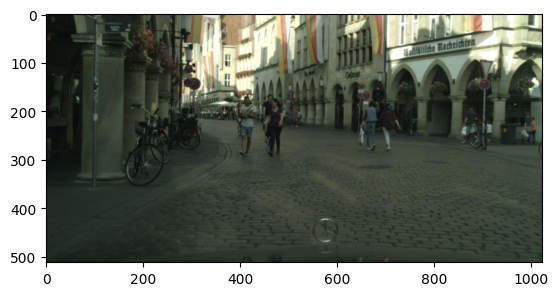

In [84]:
show_image(img[1]);

In [85]:
lbl[1].shape

torch.Size([1, 512, 1024])

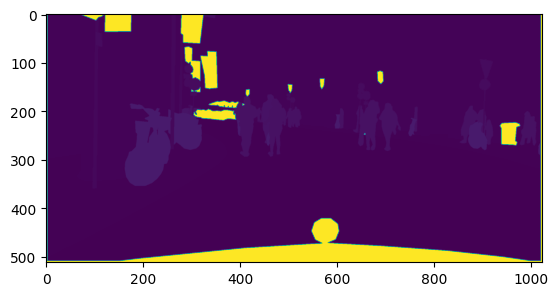

In [86]:
show_image(lbl[1]);

In [35]:
img.shape

torch.Size([5, 1024, 2048, 3])